In [1]:
import torch
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math

from torch.utils.data import DataLoader
from torchvision import models, transforms, datasets
from torch.optim.lr_scheduler import CosineAnnealingLR
import numpy as np

import copy
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
train_dir = "/kaggle/input/ham10kfolds10dataset-224x224/Fold6/train"
val_dir = "/kaggle/input/ham10kfolds10dataset-224x224/Fold6/test"
test_dir = "/kaggle/input/ham10kfolds10dataset-224x224/Fold6/test"

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

val_dataset = datasets.ImageFolder(val_dir, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

test_dataset = datasets.ImageFolder(test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Print the number of images in each dataset
print("Number of images in train dataset:", len(train_dataset))
print("Number of images in validation dataset:", len(val_dataset))
print("Number of images in test dataset:", len(test_dataset))


Number of images in train dataset: 9014
Number of images in validation dataset: 1001
Number of images in test dataset: 1001


In [5]:
num_classes = len(train_dataset.classes)

In [6]:
class ChannelGate(nn.Module):
    def __init__(self, channel, reduction=8, dropout_ratio=0.02):
        super(ChannelGate, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(),
            nn.Dropout(dropout_ratio),  # Adding dropout
            nn.Linear(channel // reduction, channel, bias=False),
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x).view(x.size(0), -1))
        max_out = self.fc(self.max_pool(x).view(x.size(0), -1))
        out = self.sigmoid(avg_out + max_out).unsqueeze(2).unsqueeze(3)
        return out * x  # Element-wise multiplication with input


class SpatialGate(nn.Module):
    def __init__(self, dropout_ratio=0.02):
        super(SpatialGate, self).__init__()
        kernel_size = 3
        self.compress = ChannelPool()
        self.spatial = nn.Sequential(
            nn.Conv2d(2, 1, kernel_size, stride=1, padding=(kernel_size-1) // 2),
            nn.Dropout(dropout_ratio)  # Adding dropout
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x_compress = self.compress(x)
        x_out = self.spatial(x_compress)
        scale = self.sigmoid(x_out)  # broadcasting
        return x * scale


class ChannelPool(nn.Module):
    def __init__(self):
        super(ChannelPool, self).__init__()

    def forward(self, x):
        x_max = torch.max(x, 1, keepdim=True)[0]
        x_avg = torch.mean(x, 1, keepdim=True)
        x_pool = torch.cat([x_max, x_avg], dim=1)
        return x_pool


class CBAM(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=8, dropout_ratio=0.02):
        super(CBAM, self).__init__()
        self.ChannelGate = ChannelGate(gate_channels, reduction_ratio, dropout_ratio)
        self.SpatialGate = SpatialGate(dropout_ratio)

    def forward(self, x):
        return self.SpatialGate(self.ChannelGate(x))


In [7]:
class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, ks, dropout_ratio=0.02):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=ks, stride=1,
                              padding=(ks - 1) // 2)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(dropout_ratio)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        x = self.dropout(x)
        return x

class ZPool(nn.Module):
    def forward(self, x):
        x_mean = x.mean(dim=1, keepdim=True)
        x_max = x.max(dim=1, keepdim=True)[0]
        return torch.cat([x_mean, x_max], dim=1)

class AttentionGate(nn.Module):
    def __init__(self, kernel_size=3, dropout_ratio=0.02):
        super().__init__()
        self.compress = ZPool()
        self.conv = BasicConv2d(2, 1, kernel_size, dropout_ratio)
        self.activation = nn.Sigmoid()

    def forward(self, x):
        y = self.compress(x)
        y = self.conv(y)
        y = self.activation(y)
        return x * y
    
class TripletAttention(nn.Module):
    def __init__(self, kernel_size=3, dropout_ratio=0.02):
        super().__init__()
        self.ch = AttentionGate(kernel_size, dropout_ratio)
        self.cw = AttentionGate(kernel_size, dropout_ratio)
        self.hw = AttentionGate(kernel_size, dropout_ratio)

    def forward(self, x):
        b, c, h, w = x.shape
        x_ch = self.ch(x.permute(0, 3, 1, 2)).permute(0, 2, 3, 1) # c and h
        x_cw = self.cw(x.permute(0, 2, 1, 3)).permute(0, 2, 1, 3)
        x_hw = self.hw(x)
        return 1 / 3 * (x_ch + x_cw + x_hw)


In [8]:
class CustomModel(nn.Module):
    def __init__(self, num_classes):
        super(CustomModel, self).__init__()
        
        base_model1 = models.densenet201(pretrained=True)

        self.base_model1= nn.Sequential(*list(base_model1.features.children())) # Remove the last two layers
       
        self.bn1 = nn.BatchNorm2d(1920)
        
        self.bn = nn.BatchNorm2d(256)

        self.dropout = nn.Dropout(0.02)
    
        # Separable convolution layers for each branch
        self.sep_conv11 = nn.Sequential(
            nn.Conv2d(1920, 512, kernel_size=3, padding=1),
            nn.Sigmoid(),
            nn.BatchNorm2d(512),
            nn.Dropout(0.02)
        )
        
        self.sep_conv12 = nn.Sequential(
            nn.Conv2d(1920, 512, kernel_size=3, padding=1),
            nn.Sigmoid(),
            nn.BatchNorm2d(512),
            nn.Dropout(0.02)
        )
        
        self.sep_conv13 = nn.Sequential(
            nn.Conv2d(1024, 512, kernel_size=3, padding=1),
            nn.Sigmoid(),
            nn.BatchNorm2d(512),
            nn.Dropout(0.02)
        )
        
        self.sep_conv4 = nn.Sequential(
            nn.Conv2d(1024, 256, kernel_size=3, padding=1),
            nn.Sigmoid(),
            nn.BatchNorm2d(256),
            nn.Dropout(0.02)
        )
        
        self.cbam1 = CBAM(512)
        self.cbam2 = CBAM(512)
        
        self.triplet_attention1 = TripletAttention(kernel_size=3) 
        self.triplet_attention2 = TripletAttention(kernel_size=3) 
    
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Fully connected layers for each branch
        self.fc = nn.Linear(256, num_classes)
        
    def forward(self, x):
        features = self.get_features(x)
        return self.classify(features)

    def get_features(self, x):
        
        x1 = self.base_model1(x)
        #rint("x1_after_basemodel1", x1.shape)
        x1 = self.bn1(x1)
        x1 = self.dropout(x1)
        #rint("x1", x1.shape)
        
        x_sep11 = self.sep_conv11(x1)
        #rint("x_sep11", x_sep11.shape)
        x_cbam11 = self.cbam1(x_sep11)
        #rint("x1_cbam11", x_cbam11.shape)
        x11 = torch.cat([x_sep11, x_cbam11], dim=1)
        #rint("x11", x11.shape)
        x_sep_mul11 = self.sep_conv13(x11)
        #rint("x_sep_mul11", x_sep_mul11.shape)
        x_cbam12 = self.cbam2(x_sep_mul11)
        x12 = torch.cat([x_sep11, x_cbam12], dim=1)
        
        x_sep12 = self.sep_conv12(x1)
        #rint("x_sep12", x_sep12.shape)
        x_triplate11 = self.triplet_attention1(x_sep12)
        #rint("x_triplate11", x_triplate11.shape)
        x21 = torch.cat([x_sep12, x_triplate11], dim = 1)
        #rint("x12", x12.shape)
        x_sep_mul12 = self.sep_conv13(x21)
        #rint("x_sep_mul12", x_sep_mul12.shape)
        x_triplate12 = self.triplet_attention2(x_sep_mul12)
        x22 = torch.cat([x_sep12, x_triplate12], dim = 1)

        final_x = torch.mul(x12,  x22)
        #rint("final_x1", final_x1.shape)
        final_x = self.dropout(final_x)
        #rint("first_half_done")
        
        x_sep = self.sep_conv4(final_x)
        #print("x_sep", x_sep.shape)
        x = self.bn(x_sep)
        
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        
        return x
    
    def classify(self, features):
        return self.fc(features)

In [9]:
def calculate_metrics(labels, preds):
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')
    return precision, recall, f1

In [10]:
def calculate_specificity_sensitivity(labels, preds):
    """Calculate sensitivity and specificity."""
    cfm = confusion_matrix(labels, preds)
    TP = cfm[1, 1]
    TN = cfm[0, 0]
    FP = cfm[0, 1]
    FN = cfm[1, 0]

    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0  # Avoid division by zero
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0  # Avoid division by zero

    return sensitivity, specificity

In [11]:
import matplotlib.pyplot as plt

def plot_metrics(train_values, val_values, title, ylabel):
    plt.figure(figsize=(6, 4))  # Set the figure size
    plt.style.use('seaborn')  # Set the plot style
    plt.title(title, fontsize=16, fontweight='bold')  # Set the title
    plt.plot(train_values, label='Training', color='blue', linewidth=2)  # Plot training values
    plt.plot(val_values, label='Validation', color='orange', linewidth=2)  # Plot validation values
    plt.xlabel('Epochs', fontsize=14)  # Set the x-label
    plt.ylabel(ylabel, fontsize=14)  # Set the y-label
    plt.legend(fontsize=12)  # Add legend
    plt.grid(True, linestyle='--', alpha=0.7)  # Add grid lines
    plt.show()  # Show the plot

In [12]:
def extract_features_and_labels(model, data_loader, device):
    model.eval()
    features = []
    labels = []

    with torch.no_grad():
        for images, batch_labels in tqdm(data_loader, desc="Extracting Features"):
            images = images.to(device)
            batch_labels = batch_labels.to(device)
            images = F.interpolate(images, size=(224, 224), mode='bilinear', align_corners=False)
            if isinstance(model, nn.DataParallel):
                output_features = model.module.get_features(images)
            else:
                output_features = model.get_features(images)
            features.extend(output_features.cpu().numpy())
            labels.extend(batch_labels.cpu().numpy())

    return {'features': np.array(features), 'labels': np.array(labels)}

In [13]:
class CustomLoss(nn.Module):
    def __init__(self, num_classes):
        super(CustomLoss, self).__init__()
        self.num_classes = num_classes
        self.initial_alpha = 0.6
        self.initial_gamma = 3
        self.initial_ce_weight = 0.2
        self.initial_focal_weight = 0.9
        self.initial_smoothing = 0.1

    def forward(self, output, target, current_epoch, total_epochs):
        # Dynamic adjustments based on the epoch number
        decay_factor = current_epoch / total_epochs
        alpha = self.initial_alpha * (1 - decay_factor)  # Decrease alpha over time
        gamma = self.initial_gamma * (1 - decay_factor)  # Decrease gamma over time
        ce_weight = self.initial_ce_weight  # Could also be adjusted dynamically
        focal_weight = self.initial_focal_weight * (1 - decay_factor)  # Decrease focal weight
        smoothing = self.initial_smoothing * (1 - decay_factor)  # Decrease smoothing

        # Adjust class weights based on the frequency of each class
        class_counts = torch.zeros(self.num_classes, device=output.device)
        for c in range(self.num_classes):
            class_counts[c] = (target == c).sum()

        epsilon = 1e-6
        class_weights = 1.0 / (class_counts + epsilon)
        class_weights = class_weights / class_weights.sum()  # normalize to sum to 1

        # Compute log probabilities
        log_probs = F.log_softmax(output, dim=1)

        # Apply label smoothing
        true_dist = torch.zeros_like(log_probs)
        true_dist.fill_(smoothing / (self.num_classes - 1))
        true_dist.scatter_(1, target.unsqueeze(1), 1 - smoothing)

        # Compute the cross-entropy loss with label smoothing
        ce_loss = torch.mean(torch.sum(-true_dist * log_probs, dim=1))

        # Compute the focal component
        pt = torch.exp(-ce_loss)
        focal_loss = alpha * (1 - pt) ** gamma * ce_loss

        # Combine the losses with respective weights
        total_loss = ce_weight * ce_loss + focal_weight * focal_loss

        return total_loss

In [14]:
def snapshot_ensemble(train_loader, val_loader, test_loader, num_classes, device):
    
    ensemble_models = []
    snapshot_epochs = [30, 70, 120]  # Adjusted snapshot epochs
    best_snapshot_weights = None

    model = CustomModel(num_classes).to(device)
    if torch.cuda.device_count() > 1:
        print("Using", torch.cuda.device_count(), "GPUs!")
        model = nn.DataParallel(model)       
    
    criterion =  CustomLoss(num_classes)
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    scheduler = CosineAnnealingLR(optimizer, T_max=snapshot_epochs[0], eta_min=1e-8)
    
    train_accs, val_accs, train_losses, val_losses, test_accs, test_losses = [], [], [], [], [], []
    learning_rates = []

    total_epochs = 120
    
    best_val_accuracy = 0

    for epoch in range(total_epochs):
        if epoch in snapshot_epochs and epoch != snapshot_epochs[-1]:
            optimizer = optim.Adam(model.parameters(), lr=0.0001)
            next_snapshot_index = snapshot_epochs.index(epoch) + 1
            epochs_until_next_snapshot = snapshot_epochs[next_snapshot_index] - epoch
            scheduler = CosineAnnealingLR(optimizer, T_max=epochs_until_next_snapshot, eta_min=1e-8)
            
        lr_rate = optimizer.param_groups[0]['lr']
        learning_rates.append(lr_rate)
        print(f"Epoch {epoch + 1}/120, Learning Rate: {lr_rate}")

        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        train_preds = []
        train_labels = []

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/120"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels, epoch, total_epochs)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            train_preds.extend(predicted.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())
        
        train_accuracy = train_correct / train_total
        train_accs.append(train_accuracy)
        train_losses.append(train_loss / train_total)
        
        train_precision = precision_score(train_labels, train_preds, average='weighted')
        train_recall = recall_score(train_labels, train_preds, average='weighted')
        train_f1 = f1_score(train_labels, train_preds, average='weighted')
        print(f"Train Loss: {train_loss / train_total:.4f}, Train Accuracy: {train_accuracy:.4f}, Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}, Train F1 Score: {train_f1:.4f}")


        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        val_preds = []
        val_labels = []

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc="Validation"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels, epoch, total_epochs)
                val_loss += loss.item() * labels.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                val_preds.extend(predicted.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())


        val_accuracy = val_correct / val_total
        val_accs.append(val_accuracy)
        val_losses.append(val_loss / val_total)
        
        val_precision = precision_score(val_labels, val_preds, average='weighted')
        val_recall = recall_score(val_labels, val_preds, average='weighted')
        val_f1 = f1_score(val_labels, val_preds, average='weighted')
        print(f"Validation Loss: {val_loss / val_total:.4f}, Validation Accuracy: {val_accuracy:.4f}, Validation Precision: {val_precision:.4f}, Validation Recall: {val_recall:.4f}, Validation F1 Score: {val_f1:.4f}")

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_snapshot_weights = copy.deepcopy(model.state_dict())
            print("Best model updated based on validation accuracy")

        if epoch + 1 in snapshot_epochs:
            
            snapshot_count = snapshot_epochs.index(epoch + 1)
            ensemble_models.append(copy.deepcopy(model))
            torch.save(model.state_dict(), f'snapshot_{snapshot_count}_model.pth')
            print(f"Snapshot {snapshot_count} saved")

            # Evaluate using the best model up to this snapshot
            model.load_state_dict(best_snapshot_weights)
            test_loss = 0
            test_correct = 0
            test_total = 0
            test_preds = []
            test_labels = []
            test_probs = []

            with torch.no_grad():
                for images, labels in tqdm(test_loader, desc="Testing"):
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels, epoch, total_epochs)
                    test_loss += loss.item() * labels.size(0)
                    _, predicted = torch.max(outputs, 1)
                    test_total += labels.size(0)
                    test_correct += (predicted == labels).sum().item()
                    test_preds.extend(predicted.cpu().numpy())
                    test_labels.extend(labels.cpu().numpy())
                    test_probs.extend(torch.softmax(outputs, dim=1)[:, 1].cpu().numpy())

            test_accuracy = test_correct / test_total
            test_accs.append(test_accuracy)
            test_losses.append(test_loss / test_total)
            
            test_accuracy = test_correct / test_total
            test_precision = precision_score(test_labels, test_preds, average='weighted')
            test_recall = recall_score(test_labels, test_preds, average='weighted')
            test_f1 = f1_score(test_labels, test_preds, average='weighted')
            print(f"Test Loss: {test_loss / test_total:.4f}, Test Accuracy: {test_accuracy:.4f}, Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}, Test F1 Score: {test_f1:.4f}")

            print("Classification Report for Test Data:")
            print(classification_report(test_labels, test_preds))
            
            # Inside the loop where you evaluate the model on the test set
            conf_matrix = confusion_matrix(test_labels, test_preds)
            
            # Calculate percentages
            conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

            # Plot confusion matrix
            plt.figure(figsize=(6, 4))
            sns.heatmap(conf_matrix_percent, annot=True, fmt='.2%', cmap='Blues')
            plt.title('Confusion Matrix')
            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')
            plt.show()

            sensitivity, specificity = calculate_specificity_sensitivity(test_labels, test_preds)
            print(f"Test Sensitivity: {sensitivity:.4f}, Test Specificity: {specificity:.4f}")

            # Plot accuracy and loss curves
            plot_metrics(train_accs, val_accs, 'Accuracy vs. Epochs', 'Accuracy')
            plot_metrics(train_losses, val_losses, 'Loss vs. Epochs', 'Loss')
            
            # Plot learning rate curve
            plt.figure(figsize=(6, 4))
            plt.plot(range(1, epoch + 2), learning_rates)
            plt.xlabel('Epoch')
            plt.ylabel('Learning Rate')
            plt.title('Learning Rate vs. Epochs')
            plt.grid(True)
            plt.show()

            # Extract and save features for train, validation, and test sets
            train_features_and_labels = extract_features_and_labels(model, train_loader, device)
            val_features_and_labels = extract_features_and_labels(model, val_loader, device)
            test_features_and_labels = extract_features_and_labels(model, test_loader, device)
            
            torch.save(train_features_and_labels, f'snapshot_{snapshot_count}_train_features.pth')
            torch.save(val_features_and_labels, f'snapshot_{snapshot_count}_val_features.pth')
            torch.save(test_features_and_labels, f'snapshot_{snapshot_count}_test_features.pth')

        scheduler.step()

    return ensemble_models

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:00<00:00, 165MB/s] 


Using 2 GPUs!
Epoch 1/120, Learning Rate: 0.0001


Epoch 1/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.4621, Train Accuracy: 0.7496, Train Precision: 0.7522, Train Recall: 0.7496, Train F1 Score: 0.7504


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.4071, Validation Accuracy: 0.8182, Validation Precision: 0.8432, Validation Recall: 0.8182, Validation F1 Score: 0.8181
Best model updated based on validation accuracy
Epoch 2/120, Learning Rate: 9.972612215893683e-05


Epoch 2/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.2190, Train Accuracy: 0.9093, Train Precision: 0.9077, Train Recall: 0.9093, Train F1 Score: 0.9080


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.3156, Validation Accuracy: 0.8571, Validation Precision: 0.8516, Validation Recall: 0.8571, Validation F1 Score: 0.8485
Best model updated based on validation accuracy
Epoch 3/120, Learning Rate: 9.890748929868662e-05


Epoch 3/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.1577, Train Accuracy: 0.9785, Train Precision: 0.9784, Train Recall: 0.9785, Train F1 Score: 0.9784


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.2949, Validation Accuracy: 0.8691, Validation Precision: 0.8724, Validation Recall: 0.8691, Validation F1 Score: 0.8678
Best model updated based on validation accuracy
Epoch 4/120, Learning Rate: 9.755307053217622e-05


Epoch 4/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.1435, Train Accuracy: 0.9931, Train Precision: 0.9931, Train Recall: 0.9931, Train F1 Score: 0.9931


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.2613, Validation Accuracy: 0.8741, Validation Precision: 0.8702, Validation Recall: 0.8741, Validation F1 Score: 0.8693
Best model updated based on validation accuracy
Epoch 5/120, Learning Rate: 9.567770515484182e-05


Epoch 5/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.1347, Train Accuracy: 0.9990, Train Precision: 0.9990, Train Recall: 0.9990, Train F1 Score: 0.9990


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.2638, Validation Accuracy: 0.8731, Validation Precision: 0.8689, Validation Recall: 0.8731, Validation F1 Score: 0.8687
Epoch 6/120, Learning Rate: 9.330194006220303e-05


Epoch 6/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.1304, Train Accuracy: 0.9999, Train Precision: 0.9999, Train Recall: 0.9999, Train F1 Score: 0.9999


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.2403, Validation Accuracy: 0.8831, Validation Precision: 0.8787, Validation Recall: 0.8831, Validation F1 Score: 0.8795
Best model updated based on validation accuracy
Epoch 7/120, Learning Rate: 9.045180463377551e-05


Epoch 7/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.1275, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.2455, Validation Accuracy: 0.8901, Validation Precision: 0.8864, Validation Recall: 0.8901, Validation F1 Score: 0.8857
Best model updated based on validation accuracy
Epoch 8/120, Learning Rate: 8.715852554974232e-05


Epoch 8/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.1261, Train Accuracy: 0.9999, Train Precision: 0.9999, Train Recall: 0.9999, Train F1 Score: 0.9999


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.2401, Validation Accuracy: 0.8961, Validation Precision: 0.8925, Validation Recall: 0.8961, Validation F1 Score: 0.8924
Best model updated based on validation accuracy
Epoch 9/120, Learning Rate: 8.345818466491112e-05


Epoch 9/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.1240, Train Accuracy: 0.9999, Train Precision: 0.9999, Train Recall: 0.9999, Train F1 Score: 0.9999


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.2394, Validation Accuracy: 0.8871, Validation Precision: 0.8832, Validation Recall: 0.8871, Validation F1 Score: 0.8828
Epoch 10/120, Learning Rate: 7.939132368836219e-05


Epoch 10/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.1231, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.2397, Validation Accuracy: 0.8881, Validation Precision: 0.8830, Validation Recall: 0.8881, Validation F1 Score: 0.8833
Epoch 11/120, Learning Rate: 7.500249999999999e-05


Epoch 11/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.1216, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.2323, Validation Accuracy: 0.8891, Validation Precision: 0.8849, Validation Recall: 0.8891, Validation F1 Score: 0.8839
Epoch 12/120, Learning Rate: 7.033979847057463e-05


Epoch 12/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.1196, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.2472, Validation Accuracy: 0.8941, Validation Precision: 0.8924, Validation Recall: 0.8941, Validation F1 Score: 0.8905
Epoch 13/120, Learning Rate: 6.54543046337755e-05


Epoch 13/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.1185, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.2331, Validation Accuracy: 0.8841, Validation Precision: 0.8784, Validation Recall: 0.8841, Validation F1 Score: 0.8775
Epoch 14/120, Learning Rate: 6.039954498243388e-05


Epoch 14/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.1172, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.2314, Validation Accuracy: 0.8901, Validation Precision: 0.8851, Validation Recall: 0.8901, Validation F1 Score: 0.8860
Epoch 15/120, Learning Rate: 5.5230900521066344e-05


Epoch 15/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.1159, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.2313, Validation Accuracy: 0.8871, Validation Precision: 0.8815, Validation Recall: 0.8871, Validation F1 Score: 0.8821
Epoch 16/120, Learning Rate: 5.000500000000001e-05


Epoch 16/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.1146, Train Accuracy: 0.9999, Train Precision: 0.9999, Train Recall: 0.9999, Train F1 Score: 0.9999


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.2317, Validation Accuracy: 0.8861, Validation Precision: 0.8805, Validation Recall: 0.8861, Validation F1 Score: 0.8807
Epoch 17/120, Learning Rate: 4.4779099478933676e-05


Epoch 17/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.1135, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.2282, Validation Accuracy: 0.8861, Validation Precision: 0.8814, Validation Recall: 0.8861, Validation F1 Score: 0.8809
Epoch 18/120, Learning Rate: 3.961045501756612e-05


Epoch 18/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.1122, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.2220, Validation Accuracy: 0.8881, Validation Precision: 0.8836, Validation Recall: 0.8881, Validation F1 Score: 0.8826
Epoch 19/120, Learning Rate: 3.455569536622451e-05


Epoch 19/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.1114, Train Accuracy: 0.9999, Train Precision: 0.9999, Train Recall: 0.9999, Train F1 Score: 0.9999


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.2180, Validation Accuracy: 0.8911, Validation Precision: 0.8864, Validation Recall: 0.8911, Validation F1 Score: 0.8858
Epoch 20/120, Learning Rate: 2.967020152942538e-05


Epoch 20/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.1099, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.2236, Validation Accuracy: 0.8931, Validation Precision: 0.8900, Validation Recall: 0.8931, Validation F1 Score: 0.8896
Epoch 21/120, Learning Rate: 2.5007500000000014e-05


Epoch 21/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.1087, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.2188, Validation Accuracy: 0.8871, Validation Precision: 0.8827, Validation Recall: 0.8871, Validation F1 Score: 0.8833
Epoch 22/120, Learning Rate: 2.0618676311637815e-05


Epoch 22/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.1075, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.2199, Validation Accuracy: 0.8901, Validation Precision: 0.8861, Validation Recall: 0.8901, Validation F1 Score: 0.8856
Epoch 23/120, Learning Rate: 1.6551815335088904e-05


Epoch 23/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.1066, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.2188, Validation Accuracy: 0.8911, Validation Precision: 0.8875, Validation Recall: 0.8911, Validation F1 Score: 0.8865
Epoch 24/120, Learning Rate: 1.285147445025769e-05


Epoch 24/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.1056, Train Accuracy: 0.9999, Train Precision: 0.9999, Train Recall: 0.9999, Train F1 Score: 0.9999


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.2118, Validation Accuracy: 0.8891, Validation Precision: 0.8848, Validation Recall: 0.8891, Validation F1 Score: 0.8835
Epoch 25/120, Learning Rate: 9.558195366224511e-06


Epoch 25/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.1044, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.2089, Validation Accuracy: 0.8881, Validation Precision: 0.8831, Validation Recall: 0.8881, Validation F1 Score: 0.8833
Epoch 26/120, Learning Rate: 6.7080599377969894e-06


Epoch 26/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.1033, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.2080, Validation Accuracy: 0.8891, Validation Precision: 0.8847, Validation Recall: 0.8891, Validation F1 Score: 0.8837
Epoch 27/120, Learning Rate: 4.3322948451581655e-06


Epoch 27/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.1023, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.2067, Validation Accuracy: 0.8901, Validation Precision: 0.8858, Validation Recall: 0.8901, Validation F1 Score: 0.8851
Epoch 28/120, Learning Rate: 2.4569294678237997e-06


Epoch 28/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.1012, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.2081, Validation Accuracy: 0.8901, Validation Precision: 0.8866, Validation Recall: 0.8901, Validation F1 Score: 0.8848
Epoch 29/120, Learning Rate: 1.1025107013133848e-06


Epoch 29/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.1003, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.2031, Validation Accuracy: 0.8931, Validation Precision: 0.8890, Validation Recall: 0.8931, Validation F1 Score: 0.8885
Epoch 30/120, Learning Rate: 2.838778410631714e-07


Epoch 30/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0993, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.2000, Validation Accuracy: 0.8871, Validation Precision: 0.8824, Validation Recall: 0.8871, Validation F1 Score: 0.8818
Snapshot 0 saved


Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Test Loss: 0.2042, Test Accuracy: 0.8961, Test Precision: 0.8925, Test Recall: 0.8961, Test F1 Score: 0.8924
Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.69      0.73      0.71        33
           1       0.82      0.88      0.85        51
           2       0.82      0.78      0.80       110
           3       0.83      0.45      0.59        11
           4       0.77      0.62      0.69       112
           5       0.94      0.98      0.96       670
           6       1.00      0.86      0.92        14

    accuracy                           0.90      1001
   macro avg       0.84      0.76      0.79      1001
weighted avg       0.89      0.90      0.89      1001



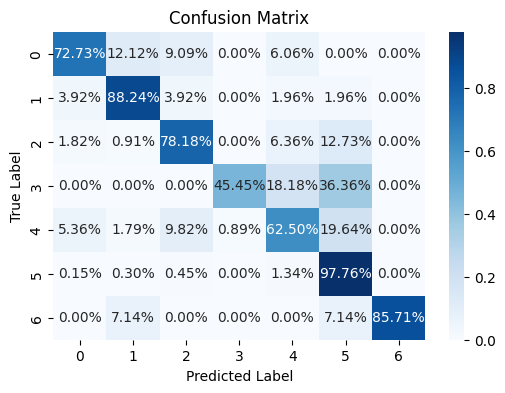

Test Sensitivity: 0.9574, Test Specificity: 0.8571


<ipython-input-11-b4d69ca1d043>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')  # Set the plot style


<ipython-input-11-b4d69ca1d043>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')  # Set the plot style


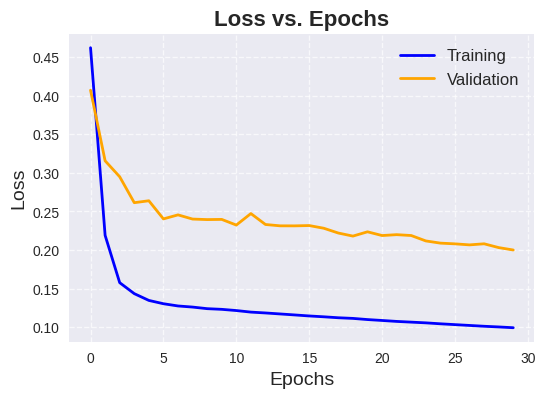

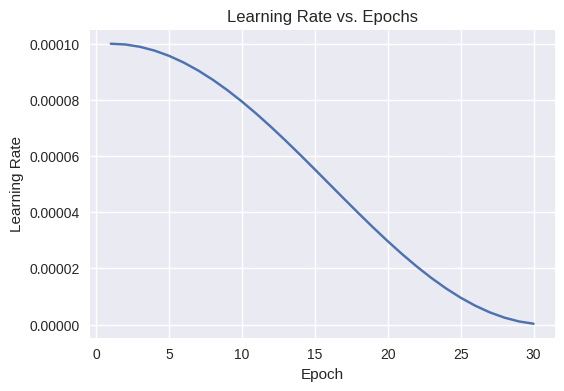

Extracting Features:   0%|          | 0/71 [00:00<?, ?it/s]

Extracting Features:   0%|          | 0/8 [00:00<?, ?it/s]

Extracting Features:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 31/120, Learning Rate: 0.0001


Epoch 31/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.1195, Train Accuracy: 0.9824, Train Precision: 0.9824, Train Recall: 0.9824, Train F1 Score: 0.9824


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.2493, Validation Accuracy: 0.8621, Validation Precision: 0.8582, Validation Recall: 0.8621, Validation F1 Score: 0.8582
Epoch 32/120, Learning Rate: 9.984588209998774e-05


Epoch 32/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.1203, Train Accuracy: 0.9760, Train Precision: 0.9760, Train Recall: 0.9760, Train F1 Score: 0.9760


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.2811, Validation Accuracy: 0.8511, Validation Precision: 0.8585, Validation Recall: 0.8511, Validation F1 Score: 0.8421
Epoch 33/120, Learning Rate: 9.938447858805392e-05


Epoch 33/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.1105, Train Accuracy: 0.9861, Train Precision: 0.9861, Train Recall: 0.9861, Train F1 Score: 0.9861


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.2161, Validation Accuracy: 0.8841, Validation Precision: 0.8805, Validation Recall: 0.8841, Validation F1 Score: 0.8788
Epoch 34/120, Learning Rate: 9.861863417028185e-05


Epoch 34/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.1038, Train Accuracy: 0.9936, Train Precision: 0.9936, Train Recall: 0.9936, Train F1 Score: 0.9936


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.2024, Validation Accuracy: 0.8851, Validation Precision: 0.8861, Validation Recall: 0.8851, Validation F1 Score: 0.8835
Epoch 35/120, Learning Rate: 9.755307053217622e-05


Epoch 35/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0978, Train Accuracy: 0.9982, Train Precision: 0.9982, Train Recall: 0.9982, Train F1 Score: 0.9982


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1983, Validation Accuracy: 0.8871, Validation Precision: 0.8828, Validation Recall: 0.8871, Validation F1 Score: 0.8828
Epoch 36/120, Learning Rate: 9.619435722790178e-05


Epoch 36/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0969, Train Accuracy: 0.9966, Train Precision: 0.9966, Train Recall: 0.9966, Train F1 Score: 0.9966


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1970, Validation Accuracy: 0.8881, Validation Precision: 0.8862, Validation Recall: 0.8881, Validation F1 Score: 0.8855
Epoch 37/120, Learning Rate: 9.455087117679744e-05


Epoch 37/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0957, Train Accuracy: 0.9971, Train Precision: 0.9971, Train Recall: 0.9971, Train F1 Score: 0.9971


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1982, Validation Accuracy: 0.8801, Validation Precision: 0.8745, Validation Recall: 0.8801, Validation F1 Score: 0.8754
Epoch 38/120, Learning Rate: 9.263274501688284e-05


Epoch 38/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0951, Train Accuracy: 0.9959, Train Precision: 0.9959, Train Recall: 0.9959, Train F1 Score: 0.9959


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.2195, Validation Accuracy: 0.8661, Validation Precision: 0.8601, Validation Recall: 0.8661, Validation F1 Score: 0.8567
Epoch 39/120, Learning Rate: 9.04518046337755e-05


Epoch 39/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0917, Train Accuracy: 0.9988, Train Precision: 0.9988, Train Recall: 0.9988, Train F1 Score: 0.9988


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.2039, Validation Accuracy: 0.8721, Validation Precision: 0.8777, Validation Recall: 0.8721, Validation F1 Score: 0.8691
Epoch 40/120, Learning Rate: 8.802149625017354e-05


Epoch 40/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0897, Train Accuracy: 0.9993, Train Precision: 0.9993, Train Recall: 0.9993, Train F1 Score: 0.9993


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1945, Validation Accuracy: 0.8831, Validation Precision: 0.8760, Validation Recall: 0.8831, Validation F1 Score: 0.8770
Epoch 41/120, Learning Rate: 8.535680352542143e-05


Epoch 41/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0880, Train Accuracy: 0.9997, Train Precision: 0.9997, Train Recall: 0.9997, Train F1 Score: 0.9997


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1873, Validation Accuracy: 0.8841, Validation Precision: 0.8776, Validation Recall: 0.8841, Validation F1 Score: 0.8781
Epoch 42/120, Learning Rate: 8.247415517626753e-05


Epoch 42/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0865, Train Accuracy: 0.9997, Train Precision: 0.9997, Train Recall: 0.9997, Train F1 Score: 0.9997


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1902, Validation Accuracy: 0.8791, Validation Precision: 0.8754, Validation Recall: 0.8791, Validation F1 Score: 0.8751
Epoch 43/120, Learning Rate: 7.939132368836218e-05


Epoch 43/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0853, Train Accuracy: 0.9998, Train Precision: 0.9998, Train Recall: 0.9998, Train F1 Score: 0.9998


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1780, Validation Accuracy: 0.8871, Validation Precision: 0.8845, Validation Recall: 0.8871, Validation F1 Score: 0.8850
Epoch 44/120, Learning Rate: 7.612731574297384e-05


Epoch 44/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0838, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1776, Validation Accuracy: 0.8861, Validation Precision: 0.8816, Validation Recall: 0.8861, Validation F1 Score: 0.8815
Epoch 45/120, Learning Rate: 7.270225503447863e-05


Epoch 45/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0826, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1789, Validation Accuracy: 0.8791, Validation Precision: 0.8737, Validation Recall: 0.8791, Validation F1 Score: 0.8745
Epoch 46/120, Learning Rate: 6.913725820109265e-05


Epoch 46/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0815, Train Accuracy: 0.9999, Train Precision: 0.9999, Train Recall: 0.9999, Train F1 Score: 0.9999


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1756, Validation Accuracy: 0.8801, Validation Precision: 0.8751, Validation Recall: 0.8801, Validation F1 Score: 0.8747
Epoch 47/120, Learning Rate: 6.54543046337755e-05


Epoch 47/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0803, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1768, Validation Accuracy: 0.8861, Validation Precision: 0.8823, Validation Recall: 0.8861, Validation F1 Score: 0.8830
Epoch 48/120, Learning Rate: 6.167610096597599e-05


Epoch 48/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0791, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1736, Validation Accuracy: 0.8851, Validation Precision: 0.8804, Validation Recall: 0.8851, Validation F1 Score: 0.8802
Epoch 49/120, Learning Rate: 5.782594107968634e-05


Epoch 49/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0780, Train Accuracy: 0.9999, Train Precision: 0.9999, Train Recall: 0.9999, Train F1 Score: 0.9999


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1697, Validation Accuracy: 0.8831, Validation Precision: 0.8773, Validation Recall: 0.8831, Validation F1 Score: 0.8778
Epoch 50/120, Learning Rate: 5.392756249091361e-05


Epoch 50/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0783, Train Accuracy: 0.9986, Train Precision: 0.9986, Train Recall: 0.9986, Train F1 Score: 0.9986


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1726, Validation Accuracy: 0.8851, Validation Precision: 0.8810, Validation Recall: 0.8851, Validation F1 Score: 0.8812
Epoch 51/120, Learning Rate: 5.0005e-05


Epoch 51/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0764, Train Accuracy: 0.9998, Train Precision: 0.9998, Train Recall: 0.9998, Train F1 Score: 0.9998


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1712, Validation Accuracy: 0.8841, Validation Precision: 0.8813, Validation Recall: 0.8841, Validation F1 Score: 0.8809
Epoch 52/120, Learning Rate: 4.60824375090864e-05


Epoch 52/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0752, Train Accuracy: 0.9998, Train Precision: 0.9998, Train Recall: 0.9998, Train F1 Score: 0.9998


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1647, Validation Accuracy: 0.8951, Validation Precision: 0.8914, Validation Recall: 0.8951, Validation F1 Score: 0.8916
Epoch 53/120, Learning Rate: 4.218405892031367e-05


Epoch 53/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0738, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1602, Validation Accuracy: 0.9021, Validation Precision: 0.8994, Validation Recall: 0.9021, Validation F1 Score: 0.8988
Best model updated based on validation accuracy
Epoch 54/120, Learning Rate: 3.833389903402401e-05


Epoch 54/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0726, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1603, Validation Accuracy: 0.8941, Validation Precision: 0.8903, Validation Recall: 0.8941, Validation F1 Score: 0.8907
Epoch 55/120, Learning Rate: 3.4555695366224505e-05


Epoch 55/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0715, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1589, Validation Accuracy: 0.8971, Validation Precision: 0.8932, Validation Recall: 0.8971, Validation F1 Score: 0.8929
Epoch 56/120, Learning Rate: 3.087274179890734e-05


Epoch 56/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0705, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1574, Validation Accuracy: 0.9041, Validation Precision: 0.9011, Validation Recall: 0.9041, Validation F1 Score: 0.9009
Best model updated based on validation accuracy
Epoch 57/120, Learning Rate: 2.730774496552136e-05


Epoch 57/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0694, Train Accuracy: 0.9999, Train Precision: 0.9999, Train Recall: 0.9999, Train F1 Score: 0.9999


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1544, Validation Accuracy: 0.8971, Validation Precision: 0.8930, Validation Recall: 0.8971, Validation F1 Score: 0.8932
Epoch 58/120, Learning Rate: 2.388268425702614e-05


Epoch 58/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0685, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1564, Validation Accuracy: 0.8961, Validation Precision: 0.8914, Validation Recall: 0.8961, Validation F1 Score: 0.8913
Epoch 59/120, Learning Rate: 2.061867631163781e-05


Epoch 59/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0674, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1528, Validation Accuracy: 0.8991, Validation Precision: 0.8956, Validation Recall: 0.8991, Validation F1 Score: 0.8954
Epoch 60/120, Learning Rate: 1.7535844823732476e-05


Epoch 60/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0664, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1506, Validation Accuracy: 0.9021, Validation Precision: 0.8991, Validation Recall: 0.9021, Validation F1 Score: 0.8985
Epoch 61/120, Learning Rate: 1.465319647457856e-05


Epoch 61/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0653, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1485, Validation Accuracy: 0.9001, Validation Precision: 0.8960, Validation Recall: 0.9001, Validation F1 Score: 0.8968
Epoch 62/120, Learning Rate: 1.1988503749826454e-05


Epoch 62/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0643, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1468, Validation Accuracy: 0.8991, Validation Precision: 0.8955, Validation Recall: 0.8991, Validation F1 Score: 0.8955
Epoch 63/120, Learning Rate: 9.558195366224508e-06


Epoch 63/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0633, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1469, Validation Accuracy: 0.8991, Validation Precision: 0.8949, Validation Recall: 0.8991, Validation F1 Score: 0.8949
Epoch 64/120, Learning Rate: 7.377254983117161e-06


Epoch 64/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0624, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1464, Validation Accuracy: 0.8981, Validation Precision: 0.8950, Validation Recall: 0.8981, Validation F1 Score: 0.8943
Epoch 65/120, Learning Rate: 5.459128823202552e-06


Epoch 65/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0614, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1437, Validation Accuracy: 0.8981, Validation Precision: 0.8943, Validation Recall: 0.8981, Validation F1 Score: 0.8939
Epoch 66/120, Learning Rate: 3.8156427720982195e-06


Epoch 66/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0604, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1422, Validation Accuracy: 0.8991, Validation Precision: 0.8947, Validation Recall: 0.8991, Validation F1 Score: 0.8956
Epoch 67/120, Learning Rate: 2.456929467823799e-06


Epoch 67/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0594, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1417, Validation Accuracy: 0.8961, Validation Precision: 0.8914, Validation Recall: 0.8961, Validation F1 Score: 0.8922
Epoch 68/120, Learning Rate: 1.3913658297181604e-06


Epoch 68/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0584, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1395, Validation Accuracy: 0.8981, Validation Precision: 0.8936, Validation Recall: 0.8981, Validation F1 Score: 0.8944
Epoch 69/120, Learning Rate: 6.255214119460928e-07


Epoch 69/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0574, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1379, Validation Accuracy: 0.9011, Validation Precision: 0.8975, Validation Recall: 0.9011, Validation F1 Score: 0.8977
Epoch 70/120, Learning Rate: 1.6411790001226747e-07


Epoch 70/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0564, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1377, Validation Accuracy: 0.8981, Validation Precision: 0.8943, Validation Recall: 0.8981, Validation F1 Score: 0.8944
Snapshot 1 saved


Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Test Loss: 0.1369, Test Accuracy: 0.9041, Test Precision: 0.9011, Test Recall: 0.9041, Test F1 Score: 0.9009
Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.83      0.76      0.79        33
           1       0.80      0.92      0.85        51
           2       0.85      0.75      0.79       110
           3       0.86      0.55      0.67        11
           4       0.78      0.68      0.73       112
           5       0.94      0.98      0.96       670
           6       1.00      0.93      0.96        14

    accuracy                           0.90      1001
   macro avg       0.87      0.79      0.82      1001
weighted avg       0.90      0.90      0.90      1001



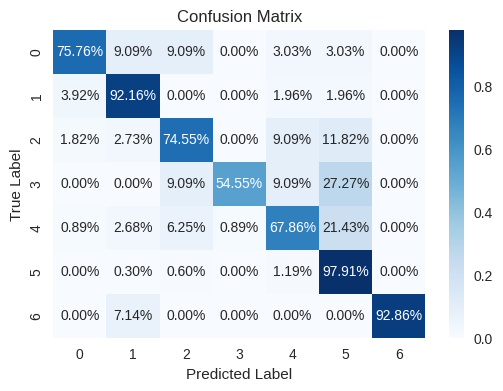

Test Sensitivity: 0.9592, Test Specificity: 0.8929


<ipython-input-11-b4d69ca1d043>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')  # Set the plot style


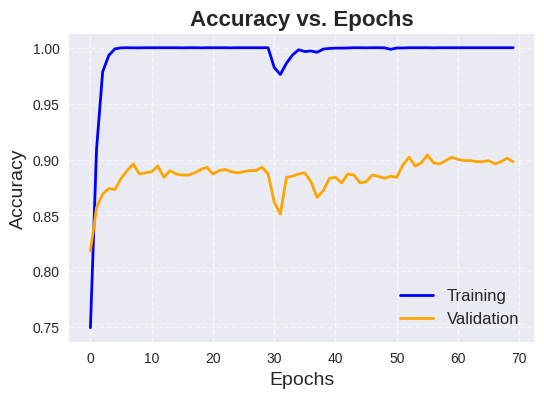

<ipython-input-11-b4d69ca1d043>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')  # Set the plot style


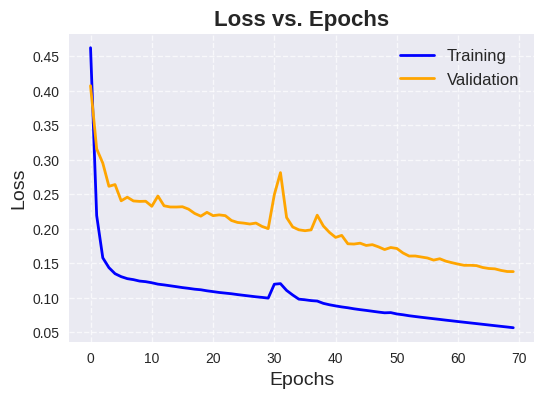

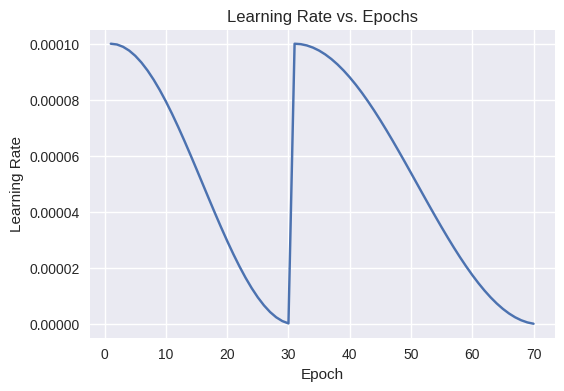

Extracting Features:   0%|          | 0/71 [00:00<?, ?it/s]

Extracting Features:   0%|          | 0/8 [00:00<?, ?it/s]

Extracting Features:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 71/120, Learning Rate: 0.0001


Epoch 71/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0613, Train Accuracy: 0.9919, Train Precision: 0.9919, Train Recall: 0.9919, Train F1 Score: 0.9919


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1953, Validation Accuracy: 0.8352, Validation Precision: 0.8524, Validation Recall: 0.8352, Validation F1 Score: 0.8375
Epoch 72/120, Learning Rate: 9.990134628777144e-05


Epoch 72/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0631, Train Accuracy: 0.9881, Train Precision: 0.9881, Train Recall: 0.9881, Train F1 Score: 0.9881


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1754, Validation Accuracy: 0.8671, Validation Precision: 0.8720, Validation Recall: 0.8671, Validation F1 Score: 0.8673
Epoch 73/120, Learning Rate: 9.960577449221733e-05


Epoch 73/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0607, Train Accuracy: 0.9912, Train Precision: 0.9912, Train Recall: 0.9912, Train F1 Score: 0.9912


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1499, Validation Accuracy: 0.8801, Validation Precision: 0.8743, Validation Recall: 0.8801, Validation F1 Score: 0.8728
Epoch 74/120, Learning Rate: 9.91144511001808e-05


Epoch 74/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0569, Train Accuracy: 0.9945, Train Precision: 0.9944, Train Recall: 0.9945, Train F1 Score: 0.9944


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1468, Validation Accuracy: 0.8711, Validation Precision: 0.8694, Validation Recall: 0.8711, Validation F1 Score: 0.8636
Epoch 75/120, Learning Rate: 9.84293151406259e-05


Epoch 75/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0541, Train Accuracy: 0.9967, Train Precision: 0.9967, Train Recall: 0.9967, Train F1 Score: 0.9967


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1552, Validation Accuracy: 0.8781, Validation Precision: 0.8768, Validation Recall: 0.8781, Validation F1 Score: 0.8693
Epoch 76/120, Learning Rate: 9.75530705321762e-05


Epoch 76/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0522, Train Accuracy: 0.9978, Train Precision: 0.9978, Train Recall: 0.9978, Train F1 Score: 0.9978


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1443, Validation Accuracy: 0.8801, Validation Precision: 0.8759, Validation Recall: 0.8801, Validation F1 Score: 0.8743
Epoch 77/120, Learning Rate: 9.648917541198312e-05


Epoch 77/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0546, Train Accuracy: 0.9925, Train Precision: 0.9925, Train Recall: 0.9925, Train F1 Score: 0.9925


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1489, Validation Accuracy: 0.8771, Validation Precision: 0.8753, Validation Recall: 0.8771, Validation F1 Score: 0.8715
Epoch 78/120, Learning Rate: 9.524182848803865e-05


Epoch 78/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0511, Train Accuracy: 0.9967, Train Precision: 0.9967, Train Recall: 0.9967, Train F1 Score: 0.9967


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1477, Validation Accuracy: 0.8701, Validation Precision: 0.8655, Validation Recall: 0.8701, Validation F1 Score: 0.8657
Epoch 79/120, Learning Rate: 9.381595246879295e-05


Epoch 79/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0493, Train Accuracy: 0.9973, Train Precision: 0.9973, Train Recall: 0.9973, Train F1 Score: 0.9973


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1463, Validation Accuracy: 0.8701, Validation Precision: 0.8648, Validation Recall: 0.8701, Validation F1 Score: 0.8617
Epoch 80/120, Learning Rate: 9.221717463547324e-05


Epoch 80/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0470, Train Accuracy: 0.9991, Train Precision: 0.9991, Train Recall: 0.9991, Train F1 Score: 0.9991


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1360, Validation Accuracy: 0.8801, Validation Precision: 0.8785, Validation Recall: 0.8801, Validation F1 Score: 0.8789
Epoch 81/120, Learning Rate: 9.04518046337755e-05


Epoch 81/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0455, Train Accuracy: 0.9996, Train Precision: 0.9996, Train Recall: 0.9996, Train F1 Score: 0.9996


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1338, Validation Accuracy: 0.8831, Validation Precision: 0.8815, Validation Recall: 0.8831, Validation F1 Score: 0.8819
Epoch 82/120, Learning Rate: 8.852680957257558e-05


Epoch 82/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0443, Train Accuracy: 0.9998, Train Precision: 0.9998, Train Recall: 0.9998, Train F1 Score: 0.9998


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1326, Validation Accuracy: 0.8781, Validation Precision: 0.8726, Validation Recall: 0.8781, Validation F1 Score: 0.8731
Epoch 83/120, Learning Rate: 8.644978652793345e-05


Epoch 83/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0433, Train Accuracy: 0.9997, Train Precision: 0.9997, Train Recall: 0.9997, Train F1 Score: 0.9997


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1322, Validation Accuracy: 0.8901, Validation Precision: 0.8881, Validation Recall: 0.8901, Validation F1 Score: 0.8865
Epoch 84/120, Learning Rate: 8.422893256090478e-05


Epoch 84/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0421, Train Accuracy: 0.9997, Train Precision: 0.9997, Train Recall: 0.9997, Train F1 Score: 0.9997


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1234, Validation Accuracy: 0.8881, Validation Precision: 0.8856, Validation Recall: 0.8881, Validation F1 Score: 0.8846
Epoch 85/120, Learning Rate: 8.187301236748573e-05


Epoch 85/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0407, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1224, Validation Accuracy: 0.8931, Validation Precision: 0.8907, Validation Recall: 0.8931, Validation F1 Score: 0.8893
Epoch 86/120, Learning Rate: 7.939132368836219e-05


Epoch 86/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0396, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1192, Validation Accuracy: 0.8951, Validation Precision: 0.8926, Validation Recall: 0.8951, Validation F1 Score: 0.8919
Epoch 87/120, Learning Rate: 7.679366061497492e-05


Epoch 87/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0385, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1188, Validation Accuracy: 0.8961, Validation Precision: 0.8945, Validation Recall: 0.8961, Validation F1 Score: 0.8926
Epoch 88/120, Learning Rate: 7.409027493671524e-05


Epoch 88/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0375, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1173, Validation Accuracy: 0.8951, Validation Precision: 0.8929, Validation Recall: 0.8951, Validation F1 Score: 0.8922
Epoch 89/120, Learning Rate: 7.12918356817958e-05


Epoch 89/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0364, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1158, Validation Accuracy: 0.8921, Validation Precision: 0.8901, Validation Recall: 0.8921, Validation F1 Score: 0.8889
Epoch 90/120, Learning Rate: 6.840938701147047e-05


Epoch 90/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0353, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1165, Validation Accuracy: 0.8891, Validation Precision: 0.8878, Validation Recall: 0.8891, Validation F1 Score: 0.8864
Epoch 91/120, Learning Rate: 6.545430463377548e-05


Epoch 91/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0343, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1151, Validation Accuracy: 0.8881, Validation Precision: 0.8852, Validation Recall: 0.8881, Validation F1 Score: 0.8845
Epoch 92/120, Learning Rate: 6.243825090880689e-05


Epoch 92/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0332, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1137, Validation Accuracy: 0.8911, Validation Precision: 0.8879, Validation Recall: 0.8911, Validation F1 Score: 0.8875
Epoch 93/120, Learning Rate: 5.93731288227133e-05


Epoch 93/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0322, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1118, Validation Accuracy: 0.8941, Validation Precision: 0.8914, Validation Recall: 0.8941, Validation F1 Score: 0.8904
Epoch 94/120, Learning Rate: 5.6271035012047397e-05


Epoch 94/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0311, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1120, Validation Accuracy: 0.8901, Validation Precision: 0.8880, Validation Recall: 0.8901, Validation F1 Score: 0.8863
Epoch 95/120, Learning Rate: 5.3144212023868024e-05


Epoch 95/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0301, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1108, Validation Accuracy: 0.8881, Validation Precision: 0.8856, Validation Recall: 0.8881, Validation F1 Score: 0.8845
Epoch 96/120, Learning Rate: 5.0005e-05


Epoch 96/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0290, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1122, Validation Accuracy: 0.8891, Validation Precision: 0.8884, Validation Recall: 0.8891, Validation F1 Score: 0.8847
Epoch 97/120, Learning Rate: 4.6865787976131975e-05


Epoch 97/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0280, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1089, Validation Accuracy: 0.8931, Validation Precision: 0.8903, Validation Recall: 0.8931, Validation F1 Score: 0.8892
Epoch 98/120, Learning Rate: 4.373896498795261e-05


Epoch 98/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0269, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1077, Validation Accuracy: 0.8891, Validation Precision: 0.8860, Validation Recall: 0.8891, Validation F1 Score: 0.8849
Epoch 99/120, Learning Rate: 4.06368711772867e-05


Epoch 99/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0259, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1071, Validation Accuracy: 0.8861, Validation Precision: 0.8839, Validation Recall: 0.8861, Validation F1 Score: 0.8824
Epoch 100/120, Learning Rate: 3.7571749091193084e-05


Epoch 100/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0249, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1062, Validation Accuracy: 0.8921, Validation Precision: 0.8902, Validation Recall: 0.8921, Validation F1 Score: 0.8886
Epoch 101/120, Learning Rate: 3.4555695366224525e-05


Epoch 101/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0238, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1061, Validation Accuracy: 0.8931, Validation Precision: 0.8897, Validation Recall: 0.8931, Validation F1 Score: 0.8891
Epoch 102/120, Learning Rate: 3.160061298852955e-05


Epoch 102/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0228, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1051, Validation Accuracy: 0.8921, Validation Precision: 0.8890, Validation Recall: 0.8921, Validation F1 Score: 0.8875
Epoch 103/120, Learning Rate: 2.8718164318204197e-05


Epoch 103/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0217, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1039, Validation Accuracy: 0.8931, Validation Precision: 0.8920, Validation Recall: 0.8931, Validation F1 Score: 0.8899
Epoch 104/120, Learning Rate: 2.5919725063284742e-05


Epoch 104/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0206, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1025, Validation Accuracy: 0.8961, Validation Precision: 0.8936, Validation Recall: 0.8961, Validation F1 Score: 0.8925
Epoch 105/120, Learning Rate: 2.3216339385025057e-05


Epoch 105/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0196, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1024, Validation Accuracy: 0.8931, Validation Precision: 0.8908, Validation Recall: 0.8931, Validation F1 Score: 0.8891
Epoch 106/120, Learning Rate: 2.0618676311637815e-05


Epoch 106/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0185, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1031, Validation Accuracy: 0.8921, Validation Precision: 0.8905, Validation Recall: 0.8921, Validation F1 Score: 0.8876
Epoch 107/120, Learning Rate: 1.8136987632514258e-05


Epoch 107/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0174, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1009, Validation Accuracy: 0.8921, Validation Precision: 0.8887, Validation Recall: 0.8921, Validation F1 Score: 0.8879
Epoch 108/120, Learning Rate: 1.578106743909521e-05


Epoch 108/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0163, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1010, Validation Accuracy: 0.8941, Validation Precision: 0.8921, Validation Recall: 0.8941, Validation F1 Score: 0.8901
Epoch 109/120, Learning Rate: 1.356021347206654e-05


Epoch 109/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0152, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1010, Validation Accuracy: 0.8901, Validation Precision: 0.8886, Validation Recall: 0.8901, Validation F1 Score: 0.8862
Epoch 110/120, Learning Rate: 1.148319042742442e-05


Epoch 110/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0141, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1008, Validation Accuracy: 0.8951, Validation Precision: 0.8933, Validation Recall: 0.8951, Validation F1 Score: 0.8905
Epoch 111/120, Learning Rate: 9.558195366224506e-06


Epoch 111/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0130, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1007, Validation Accuracy: 0.8941, Validation Precision: 0.8916, Validation Recall: 0.8941, Validation F1 Score: 0.8897
Epoch 112/120, Learning Rate: 7.792825364526766e-06


Epoch 112/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0118, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1003, Validation Accuracy: 0.8921, Validation Precision: 0.8896, Validation Recall: 0.8921, Validation F1 Score: 0.8878
Epoch 113/120, Learning Rate: 6.1940475312070395e-06


Epoch 113/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0107, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1005, Validation Accuracy: 0.8911, Validation Precision: 0.8885, Validation Recall: 0.8911, Validation F1 Score: 0.8865
Epoch 114/120, Learning Rate: 4.768171511961362e-06


Epoch 114/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0095, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.0999, Validation Accuracy: 0.8921, Validation Precision: 0.8889, Validation Recall: 0.8921, Validation F1 Score: 0.8882
Epoch 115/120, Learning Rate: 3.5208245880168734e-06


Epoch 115/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0083, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1012, Validation Accuracy: 0.8871, Validation Precision: 0.8826, Validation Recall: 0.8871, Validation F1 Score: 0.8825
Epoch 116/120, Learning Rate: 2.456929467823799e-06


Epoch 116/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0071, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1012, Validation Accuracy: 0.8911, Validation Precision: 0.8892, Validation Recall: 0.8911, Validation F1 Score: 0.8863
Epoch 117/120, Learning Rate: 1.5806848593740944e-06


Epoch 117/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0059, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1021, Validation Accuracy: 0.8911, Validation Precision: 0.8888, Validation Recall: 0.8911, Validation F1 Score: 0.8864
Epoch 118/120, Learning Rate: 8.955488998192071e-07


Epoch 118/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0047, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1009, Validation Accuracy: 0.8911, Validation Precision: 0.8876, Validation Recall: 0.8911, Validation F1 Score: 0.8869
Epoch 119/120, Learning Rate: 4.0422550778268403e-07


Epoch 119/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0034, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.0986, Validation Accuracy: 0.8911, Validation Precision: 0.8876, Validation Recall: 0.8911, Validation F1 Score: 0.8868
Epoch 120/120, Learning Rate: 1.0865371222856339e-07


Epoch 120/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0022, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.0998, Validation Accuracy: 0.8911, Validation Precision: 0.8875, Validation Recall: 0.8911, Validation F1 Score: 0.8866
Snapshot 2 saved


Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Test Loss: 0.0801, Test Accuracy: 0.9041, Test Precision: 0.9011, Test Recall: 0.9041, Test F1 Score: 0.9009
Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.83      0.76      0.79        33
           1       0.80      0.92      0.85        51
           2       0.85      0.75      0.79       110
           3       0.86      0.55      0.67        11
           4       0.78      0.68      0.73       112
           5       0.94      0.98      0.96       670
           6       1.00      0.93      0.96        14

    accuracy                           0.90      1001
   macro avg       0.87      0.79      0.82      1001
weighted avg       0.90      0.90      0.90      1001



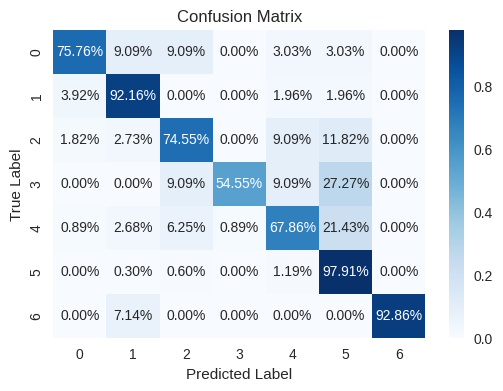

Test Sensitivity: 0.9592, Test Specificity: 0.8929


<ipython-input-11-b4d69ca1d043>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')  # Set the plot style


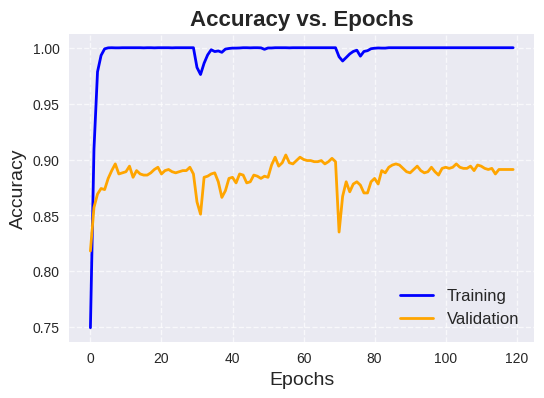

<ipython-input-11-b4d69ca1d043>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')  # Set the plot style


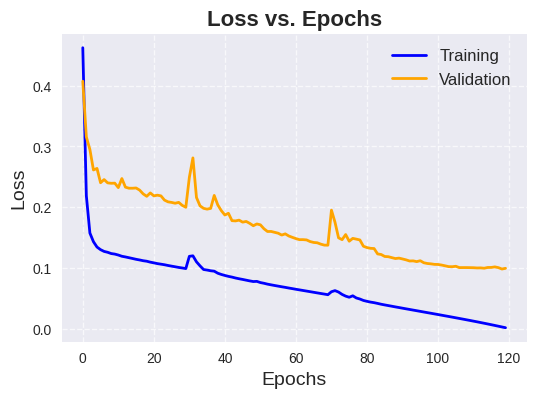

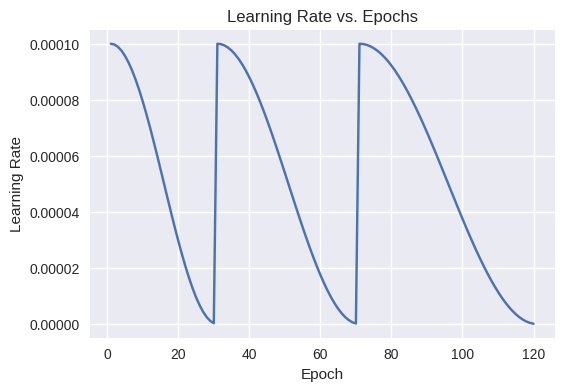

Extracting Features:   0%|          | 0/71 [00:00<?, ?it/s]

Extracting Features:   0%|          | 0/8 [00:00<?, ?it/s]

Extracting Features:   0%|          | 0/8 [00:00<?, ?it/s]

In [15]:
ensemble_models = snapshot_ensemble(train_loader, val_loader, test_loader, num_classes, device)

In [16]:
import torch
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split


In [17]:
# Define paths
train_feature_paths = [
    "/kaggle/working/snapshot_0_train_features.pth",
    "/kaggle/working/snapshot_1_train_features.pth",
    "/kaggle/working/snapshot_2_train_features.pth"
]

test_feature_paths = [
    "/kaggle/working/snapshot_0_test_features.pth",
    "/kaggle/working/snapshot_1_test_features.pth",
    "/kaggle/working/snapshot_2_test_features.pth"
]


# ****Feature Extraction, Concatenation and Save it into CSV file format****

In [18]:
import numpy as np
import torch

def load_features(paths):
    """Load and horizontally concatenate features from multiple files."""
    combined_features = []
    for path in paths:
        data = torch.load(path)
        features = data['features']
        if isinstance(features, torch.Tensor):
            features = features.numpy()
        # Exclude the last column, which contains labels
        features = features[:, :-1]
        combined_features.append(features)
    # Horizontally concatenate features (not vertically)
    concatenated_features = np.concatenate(combined_features, axis=1)
    return concatenated_features

# Load features from paths and concatenate with labels separately
train_features = load_features(train_feature_paths)
test_features = load_features(test_feature_paths)

# Load labels separately
train_labels = torch.load("/kaggle/working/snapshot_2_train_features.pth")['labels']
test_labels = torch.load("/kaggle/working/snapshot_2_test_features.pth")['labels']

# Print the shape of the features
print("Shape of concatenated train features:", train_features.shape)
print("Shape of concatenated test features:", test_features.shape)

# Save features and labels to CSV files
train_data_with_labels = np.column_stack((train_features, train_labels))
test_data_with_labels = np.column_stack((test_features, test_labels))

np.savetxt('train_data_with_labels_Ham10K.csv', train_data_with_labels, delimiter=',')
np.savetxt('test_data_with_labels_Ham10K.csv', test_data_with_labels, delimiter=',')


<ipython-input-18-5f001c331952>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(path)
<ipython-input-18-5f001c331952>:24: FutureWarning: You are using `to

Shape of concatenated train features: (9014, 765)
Shape of concatenated test features: (1001, 765)


In [19]:
import numpy as np

# Load labels from CSV files
train_labels = np.loadtxt('/kaggle/working/train_data_with_labels_Ham10K.csv', delimiter=',', usecols=-1)
test_labels = np.loadtxt('/kaggle/working/test_data_with_labels_Ham10K.csv', delimiter=',', usecols=-1)

# Calculate the frequency of each class in the train set
train_classes, train_counts = np.unique(train_labels, return_counts=True)
print("Train set class frequencies:")
for cls, count in zip(train_classes, train_counts):
    print(f"Class {int(cls)}: {count} samples")

# Calculate the frequency of each class in the test set
test_classes, test_counts = np.unique(test_labels, return_counts=True)
print("\nTest set class frequencies:")
for cls, count in zip(test_classes, test_counts):
    print(f"Class {int(cls)}: {count} samples")


Train set class frequencies:
Class 0: 294 samples
Class 1: 463 samples
Class 2: 989 samples
Class 3: 104 samples
Class 4: 1001 samples
Class 5: 6035 samples
Class 6: 128 samples

Test set class frequencies:
Class 0: 33 samples
Class 1: 51 samples
Class 2: 110 samples
Class 3: 11 samples
Class 4: 112 samples
Class 5: 670 samples
Class 6: 14 samples


# ****Feature Selection Using SelectKBest Method:****

In [20]:
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm

# Load data from CSV files with labels
train_data = np.loadtxt('/kaggle/working/train_data_with_labels_Ham10K.csv', delimiter=',')
test_data = np.loadtxt('/kaggle/working/test_data_with_labels_Ham10K.csv', delimiter=',')

X_train = train_data[:, :-1]  # Features
y_train = train_data[:, -1]   # Labels

X_test = test_data[:, :-1]   # Features
y_test = test_data[:, -1]    # Labels

def feature_selection(X_train, y_train, X_test, k=5):
    """Perform feature selection using SelectKBest with ANOVA F-value."""
    # Initialize SelectKBest with the desired number of features to select
    selector = SelectKBest(f_classif, k=k)
    
    # Fit SelectKBest on the training data
    selector.fit(X_train, y_train)
    
    # Get indices of selected features
    selected_feature_indices = selector.get_support(indices=True)
    
    return selected_feature_indices

# Initialize lists to store accuracies
svm_accuracies = []
rf_accuracies = []

with tqdm(total=X_train.shape[1], desc="Feature Selection Progress") as pbar:
    for k in range(1, X_train.shape[1] + 1):
        selected_feature_indices_train = feature_selection(X_train, y_train, X_test, k=k)
        X_train_selected = X_train[:, selected_feature_indices_train]
        X_test_selected = X_test[:, selected_feature_indices_train]

        # Feature scaling
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_selected)
        X_test_scaled = scaler.transform(X_test_selected)

        # Random Forest
        rf_classifier = RandomForestClassifier(n_estimators=10, random_state=42)
        rf_classifier.fit(X_train_scaled, y_train)
        rf_predictions = rf_classifier.predict(X_test_scaled)
        rf_accuracy = accuracy_score(y_test, rf_predictions)
        rf_accuracies.append(rf_accuracy)

        # Support Vector Machine
        svm_classifier = SVC(kernel='rbf', random_state=42)
        svm_classifier.fit(X_train_scaled, y_train)
        svm_predictions = svm_classifier.predict(X_test_scaled)
        svm_accuracy = accuracy_score(y_test, svm_predictions)
        svm_accuracies.append(svm_accuracy)
        
        pbar.update(1)

# Print accuracies for all k values
print("SVM Accuracies for all k values:")
for k, accuracy in enumerate(svm_accuracies, start=1):
    print(f"k={k}: {accuracy}")

print("\nRandom Forest Accuracies for all k values:")
for k, accuracy in enumerate(rf_accuracies, start=1):
    print(f"k={k}: {accuracy}")

# Find the k value with the highest accuracy for both SVM and RF
best_k_svm = np.argmax(svm_accuracies) + 1
best_accuracy_svm = svm_accuracies[best_k_svm - 1]

best_k_rf = np.argmax(rf_accuracies) + 1
best_accuracy_rf = rf_accuracies[best_k_rf - 1]

print("\nBest SVM Accuracy:", best_accuracy_svm, "achieved with k =", best_k_svm)
print("Best RF Accuracy:", best_accuracy_rf, "achieved with k =", best_k_rf)

# Select the features for the best accuracies
selected_feature_indices_svm = feature_selection(X_train, y_train, X_test, k=best_k_svm)
X_train_selected_svm = X_train[:, selected_feature_indices_svm]
X_test_selected_svm = X_test[:, selected_feature_indices_svm]

selected_feature_indices_rf = feature_selection(X_train, y_train, X_test, k=best_k_rf)
X_train_selected_rf = X_train[:, selected_feature_indices_rf]
X_test_selected_rf = X_test[:, selected_feature_indices_rf]

# Feature scaling
scaler = StandardScaler()
X_train_scaled_svm = scaler.fit_transform(X_train_selected_svm)
X_test_scaled_svm = scaler.transform(X_test_selected_svm)

X_train_scaled_rf = scaler.fit_transform(X_train_selected_rf)
X_test_scaled_rf = scaler.transform(X_test_selected_rf)

# Train SVM with the best k
best_svm_classifier = SVC(kernel='rbf', random_state=42)
best_svm_classifier.fit(X_train_scaled_svm, y_train)
svm_predictions = best_svm_classifier.predict(X_test_scaled_svm)

# Train RF with the best k
best_rf_classifier = RandomForestClassifier(n_estimators=10, random_state=42)
best_rf_classifier.fit(X_train_scaled_rf, y_train)
rf_predictions = best_rf_classifier.predict(X_test_scaled_rf)

# Print classification reports
print("\nClassification Report for Best SVM:")
svm_report = classification_report(y_test, svm_predictions, output_dict=True)
for key, value in svm_report.items():
    if key != 'accuracy':
        print(f"{key}: {value['precision']:.4f}, {value['recall']:.4f}, {value['f1-score']:.4f}, {value['support']}")

print("\nClassification Report for Best Random Forest:")
rf_report = classification_report(y_test, rf_predictions, output_dict=True)
for key, value in rf_report.items():
    if key != 'accuracy':
        print(f"{key}: {value['precision']:.4f}, {value['recall']:.4f}, {value['f1-score']:.4f}, {value['support']}")


Feature Selection Progress: 100%|██████████| 765/765 [19:37<00:00,  1.54s/it]


SVM Accuracies for all k values:
k=1: 0.7792207792207793
k=2: 0.8091908091908092
k=3: 0.8051948051948052
k=4: 0.8221778221778222
k=5: 0.8471528471528471
k=6: 0.8541458541458542
k=7: 0.8631368631368631
k=8: 0.8641358641358642
k=9: 0.8751248751248751
k=10: 0.8801198801198801
k=11: 0.8811188811188811
k=12: 0.8871128871128872
k=13: 0.8821178821178821
k=14: 0.8851148851148851
k=15: 0.8871128871128872
k=16: 0.8891108891108891
k=17: 0.8871128871128872
k=18: 0.8901098901098901
k=19: 0.8911088911088911
k=20: 0.8901098901098901
k=21: 0.8931068931068931
k=22: 0.8961038961038961
k=23: 0.8951048951048951
k=24: 0.8971028971028971
k=25: 0.8971028971028971
k=26: 0.8971028971028971
k=27: 0.8951048951048951
k=28: 0.8971028971028971
k=29: 0.8971028971028971
k=30: 0.8951048951048951
k=31: 0.8951048951048951
k=32: 0.8971028971028971
k=33: 0.8971028971028971
k=34: 0.9020979020979021
k=35: 0.903096903096903
k=36: 0.903096903096903
k=37: 0.903096903096903
k=38: 0.9020979020979021
k=39: 0.9020979020979021
k=40

In [21]:
import torch
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [22]:
def preprocess_image(img_path, size=(224, 224)):
    img = Image.open(img_path).convert('RGB')
    preprocessing = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    img_tensor = preprocessing(img).unsqueeze(0)  # Add batch dimension
    return img_tensor


def make_gradcam_heatmap(img_tensor, model, target_layer):
    model.eval()
    # Register hook for the activations
    activations = []
    def forward_hook(module, input, output):
        activations.append(output)

    # Register hook for the gradients
    gradients = []
    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    # Find last conv layer inside the target_layer to register the hooks
    last_conv_layer = None
    for layer in reversed(target_layer):
        if isinstance(layer, torch.nn.Conv2d):
            last_conv_layer = layer
            break
    if last_conv_layer is None:
        raise ValueError("No convolution layers found in target_layer")

    forward_handle = last_conv_layer.register_forward_hook(forward_hook)
    backward_handle = last_conv_layer.register_backward_hook(backward_hook)

    # Forward pass
    output = model(img_tensor)
    _, predicted = torch.max(output, 1)
    pred_index = predicted.item()

    # Backward pass
    model.zero_grad()
    class_loss = F.one_hot(torch.tensor([pred_index]), num_classes=output.shape[1]).float() @ output.t()
    class_loss.backward()

    # Remove hooks
    forward_handle.remove()
    backward_handle.remove()

    # Get the gradient and activation of the target layer
    activation = activations[0].squeeze()
    gradient = gradients[0].squeeze()

    # Pool gradients and create heatmap
    pooled_gradients = torch.mean(gradient, dim=[1, 2])
    weighted_activation = torch.zeros_like(activation)
    for i in range(pooled_gradients.shape[0]):
        weighted_activation[i, :, :] = activation[i, :, :] * pooled_gradients[i]
    heatmap = torch.mean(weighted_activation, dim=0)
    heatmap = torch.clamp(heatmap, min=0)
    heatmap /= torch.max(heatmap)

    return heatmap.detach().cpu().numpy()

In [23]:
from PIL import Image
import matplotlib.cm as cm
import matplotlib.pyplot as plt

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = Image.open(img_path).convert('RGB')
    img = img.resize((224, 224))  # Resize to match the heatmap
    img = np.array(img)
    
    # Normalize heatmap to be between 0 and 1, then convert to RGB
    heatmap = np.uint8(255 * heatmap)  # Scale to 0-255 to use with a colormap
    jet = cm.get_cmap("jet")  # Get the "jet" colormap
    jet_colors = jet(np.arange(256))[:, :3]  # Use only the RGB channels
    jet_heatmap = jet_colors[heatmap]  # Map the heatmap through the colormap

    jet_heatmap = Image.fromarray((jet_heatmap * 255).astype(np.uint8))  # Convert to an image
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))  # Resize to match img
    jet_heatmap = np.array(jet_heatmap)  # Convert back to an array to do further operations

    # Superimpose the heatmap on the original image
    superimposed_img = jet_heatmap * alpha + img * (1 - alpha)
    superimposed_img = Image.fromarray(np.uint8(superimposed_img))

    # Display original and heatmap images
    plt.figure(figsize=(6, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img)
    plt.title('Grad-CAM')
    plt.axis('off')

    plt.show()

In [24]:
# Load the model and prepare the image
model = CustomModel(num_classes=7)  # Adjust the number of classes as necessary
target_layer = model.sep_conv4  # Selecting the target layer for visualization

img_path = '/kaggle/input/hamtraintest-224x224/content/HamTrainTest/test/mel/ISIC_0025035.jpg'
img_tensor = preprocess_image(img_path)
heatmap = make_gradcam_heatmap(img_tensor, model, target_layer)
save_and_display_gradcam(img_path, heatmap)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/hamtraintest-224x224/content/HamTrainTest/test/mel/ISIC_0025035.jpg'

In [ ]:
# Load the model and prepare the image
model = CustomModel(num_classes=7)  # Adjust the number of classes as necessary
target_layer = model.sep_conv4  # Selecting the target layer for visualization

img_path = "/kaggle/input/hamtraintest-224x224/content/HamTrainTest/test/nv/ISIC_0024320.jpg"
img_tensor = preprocess_image(img_path)
heatmap = make_gradcam_heatmap(img_tensor, model, target_layer)
save_and_display_gradcam(img_path, heatmap)

In [ ]:
def make_gradcam_heatmap(img_tensor, model, target_layer):
    model.eval()
    # Register hook for the activations
    activations = []
    def forward_hook(module, input, output):
        activations.append(output)

    # Register hook for the gradients
    gradients = []
    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    # Find last conv layer inside the target_layer to register the hooks
    last_conv_layer = None
    for layer in reversed(target_layer):
        if isinstance(layer, torch.nn.Conv2d):
            last_conv_layer = layer
            break
    if last_conv_layer is None:
        raise ValueError("No convolution layers found in target_layer")

    forward_handle = last_conv_layer.register_forward_hook(forward_hook)
    backward_handle = last_conv_layer.register_backward_hook(backward_hook)

    # Forward pass
    output = model(img_tensor)
    _, predicted = torch.max(output, 1)
    pred_index = predicted.item()

    # Backward pass
    model.zero_grad()
    class_loss = F.one_hot(torch.tensor([pred_index]), num_classes=output.shape[1]).float() @ output.t()
    class_loss.backward()

    # Remove hooks
    forward_handle.remove()
    backward_handle.remove()

    # Get the gradient and activation of the target layer
    activation = activations[0].squeeze()
    gradient = gradients[0].squeeze()

    # Pool gradients and create heatmap
    pooled_gradients = torch.mean(gradient, dim=[1, 2], keepdim=True)
    weighted_activation = (activation * pooled_gradients).mean(dim=0)
    heatmap = weighted_activation.relu()

    return heatmap.detach().cpu().numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = Image.open(img_path).convert('RGB')
    img = img.resize((heatmap.shape[1], heatmap.shape[0]))  # Resize to match the heatmap
    img = np.array(img)

    # Normalize heatmap to be between 0 and 1, then convert to RGB
    heatmap = np.uint8(255 * heatmap)  # Scale to 0-255 to use with a colormap
    jet = cm.get_cmap("jet")  # Get the "jet" colormap
    jet_colors = jet(np.arange(256))[:, :3]  # Use only the RGB channels
    jet_heatmap = jet_colors[heatmap]  # Map the heatmap through the colormap
    
    jet_heatmap = Image.fromarray((jet_heatmap * 255).astype(np.uint8))  # Convert to an image
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))  # Resize to match img
    jet_heatmap = np.array(jet_heatmap)  # Convert back to an array to do further operations

    # Superimpose the heatmap on the original image
    superimposed_img = jet_heatmap * alpha + img * (1 - alpha)
    superimposed_img = Image.fromarray(np.uint8(superimposed_img))

    # Display original and heatmap images
    plt.figure(figsize=(6, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img)
    plt.title('Grad-CAM')
    plt.axis('off')

    plt.show()


In [ ]:
# Load the model and prepare the image
model = CustomModel(num_classes=3)  # Adjust the number of classes as necessary
target_layer = model.sep_conv4  # Selecting the target layer for visualization

img_path = "/kaggle/input/hamtraintest-224x224/content/HamTrainTest/test/nv/ISIC_0024320.jpg"
img_tensor = preprocess_image(img_path)
heatmap = make_gradcam_heatmap(img_tensor, model, target_layer)
save_and_display_gradcam(img_path, heatmap)